# Mortality risk prediction

This tutorial will walk you through building a population-level risk prediction model from scratch, following the exact supervised framework outlined in your lecture.

**Our Goal**: Predict 1-year mortality for patients following their first adult ICU admission.

**Our Model**: We will use the L1-regularized logistic regression (LASSO) model mentioned in your slides to create a strong, interpretable baseline.

In [43]:
## Import libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Load the data

In [44]:
data_path = "data/mimic IV/" ## Replace with your own path
patients = pd.read_csv(os.path.join(data_path,'patients.csv.gz'))
admissions = pd.read_csv(os.path.join(data_path,'admissions.csv.gz'))
icustays = pd.read_csv(os.path.join(data_path,'icustays.csv.gz'))
diagnoses = pd.read_csv(os.path.join(data_path,'diagnoses_icd.csv.gz'))
procedures = pd.read_csv(os.path.join(data_path,'procedures_icd.csv.gz'))

**Q1**: How many patients do you have in this dataset?

In [45]:
# Convert key columns to datetime objects ---
# This is crucial for temporal calculations
patients['dod'] = pd.to_datetime(patients['dod']) ##date of death
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

In [46]:
# Get Patient Demographics (Age)
# We merge admissions and patients to get age at admission
admissions = admissions.merge(patients[['subject_id', 'anchor_age', 'anchor_year', 'dod']], on='subject_id')


# Calculate age. Note: This is an approximation based on MIMIC's anchoring.
admissions['age_at_admission'] = admissions['anchor_age'] + (pd.to_datetime(admissions['admittime']).dt.year - admissions['anchor_year'])

In [47]:
patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaT
2,10000058,F,33,2168,2020 - 2022,NaT
3,10000068,F,19,2160,2008 - 2010,NaT
4,10000084,M,72,2160,2017 - 2019,2161-02-13
...,...,...,...,...,...,...
364622,19999828,F,46,2147,2017 - 2019,NaT
364623,19999829,F,28,2186,2008 - 2010,NaT
364624,19999840,M,58,2164,2008 - 2010,2164-09-17
364625,19999914,F,49,2158,2017 - 2019,NaT


# Merge with image identifier

In [48]:
image_link = pd.read_csv('data/cxr-record-list.csv.gz')
image_metadata = pd.read_csv('data/mimic-cxr-2.0.0-metadata.csv.gz')
image_metadata['StudyDate'] = pd.to_datetime(image_metadata['StudyDate'], format='%Y%m%d')


In [49]:
image_link

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...
...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...


In [50]:
image_metadata

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


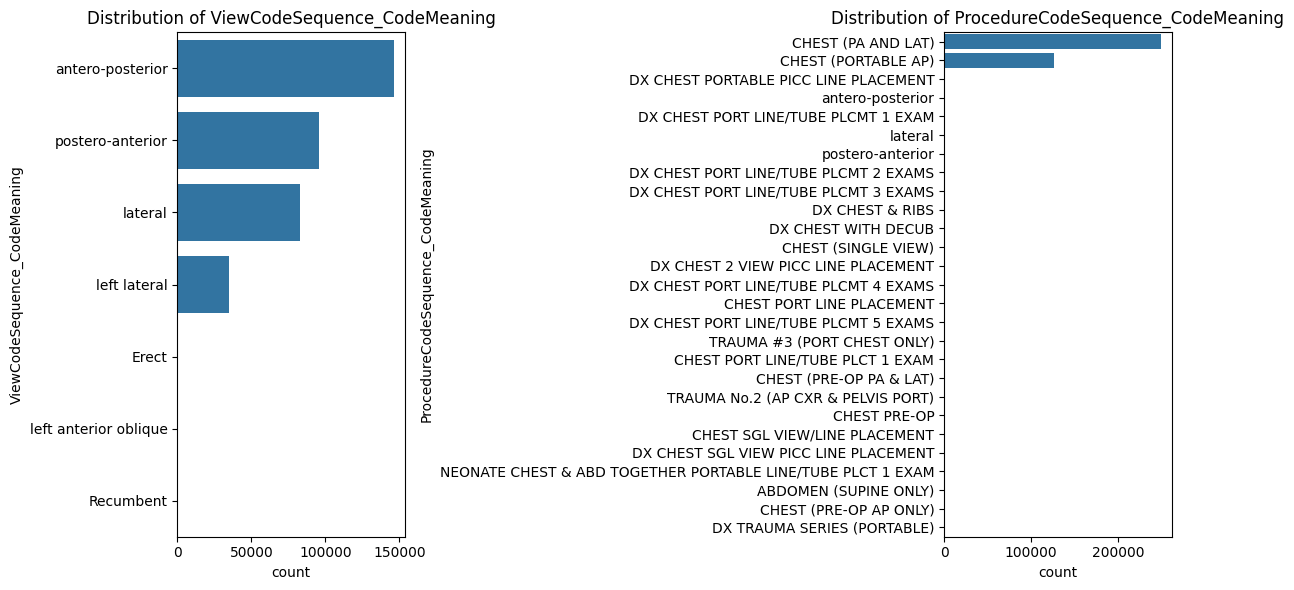

In [51]:
# plot distribution of 'ViewCodeSequence_CodeMeaning' and 'ProcedureCodeSequence_CodeMeaning'
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(y='ViewCodeSequence_CodeMeaning', data=image_metadata, order=image_metadata['ViewCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ViewCodeSequence_CodeMeaning')
plt.subplot(1,2,2)
sns.countplot(y='ProcedureCodeSequence_CodeMeaning', data=image_metadata, order=image_metadata['ProcedureCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ProcedureCodeSequence_CodeMeaning')
plt.tight_layout()  
plt.show()

In [52]:
# merge image_link with image_metadata to add StudyDate
image_link = image_link.merge(image_metadata[['dicom_id', 'StudyDate']], on='dicom_id', how='left')

In [53]:
image_link

,subject_id,study_id,dicom_id,path,StudyDate
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,2180-05-06
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,2180-06-26
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,2180-06-26
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,2180-07-23
...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,2152-07-08
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,2152-07-08
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,2145-11-04
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,2145-11-02


In [54]:
# number of unique patients
print(f"Number of unique patients with CXR images: {image_link['subject_id'].nunique()}")

Number of unique patients with CXR images: 65379


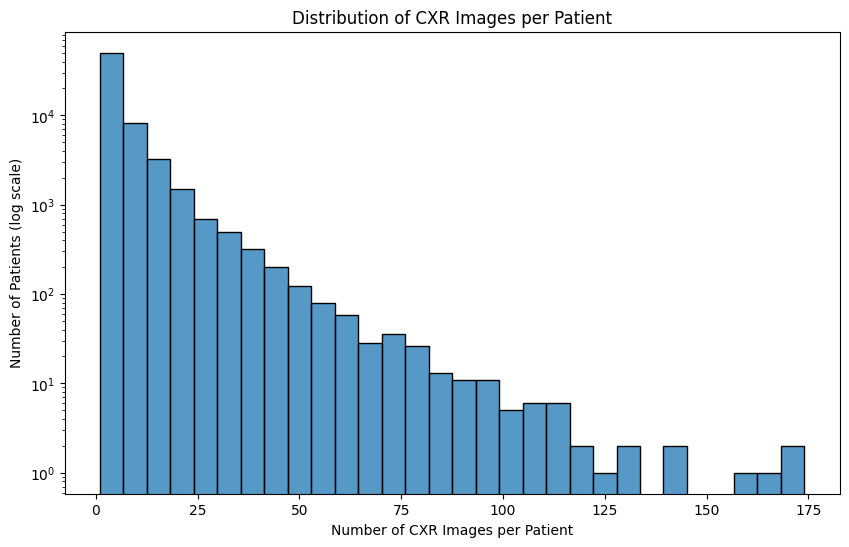

In [55]:
# distribution of number of CXR images per patient
image_counts = image_link['subject_id'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(image_counts, bins=30, kde=False)
plt.yscale('log')
plt.xlabel('Number of CXR Images per Patient')
plt.ylabel('Number of Patients (log scale)')
plt.title('Distribution of CXR Images per Patient')
plt.show()

# Merge patients with their dicom files

In [56]:
# merge image_link with patients
image_link = image_link.merge(patients[['subject_id', 'dod', 'gender']], on='subject_id', how='left')
image_link

,subject_id,study_id,dicom_id,path,StudyDate,dod,gender
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06,2180-09-09,F
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,2180-05-06,2180-09-09,F
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,2180-06-26,2180-09-09,F
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,2180-06-26,2180-09-09,F
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,2180-07-23,2180-09-09,F
...,...,...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,2152-07-08,NaT,F
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,2152-07-08,NaT,F
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,2145-11-04,NaT,F
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,2145-11-02,NaT,F


### Lets start and use only the first scan of each patient
### (the prediction task is therefore: survival prediction after first scan)

In [57]:
# for patients with multiple images, keep the earliest image
image_link = image_link.sort_values(by=['subject_id', 'StudyDate']).drop_duplicates(subset=['subject_id'], keep='first')

# replace .dcm with .tfrecord in the file_path
image_link['path'] = image_link['path'].str.replace('.dcm', '.tfrecord')

In [58]:
image_link

,subject_id,study_id,dicom_id,path,StudyDate,dod,gender
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06,2180-09-09,F
7,10000764,57375967,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,files/p10/p10000764/s57375967/096052b7-d256dc4...,2132-10-15,NaT,M
12,10000898,54205396,8959e402-2175d68d-edba5a6c-baab51c3-9359f700,files/p10/p10000898/s54205396/8959e402-2175d68...,2188-01-13,NaT,F
22,10000935,56522600,6fa5997e-b1dfecf8-3c174666-8815c84a-32db59ff,files/p10/p10000935/s56522600/6fa5997e-b1dfecf...,2186-07-30,2187-11-12,F
39,10000980,59988438,57a3c797-7272b246-fa226777-e4c7d84c-91ec2e96,files/p10/p10000980/s59988438/57a3c797-7272b24...,2188-01-03,2193-08-26,F
...,...,...,...,...,...,...,...
377098,19999287,53282218,5a5eddf4-b64e5e49-f6e9c8bc-d6409b00-015470ea,files/p19/p19999287/s53282218/5a5eddf4-b64e5e4...,2196-11-27,2197-09-02,F
377101,19999376,57540554,53e9b6d0-5d5317f5-f1a4c031-01d40558-fd14a425,files/p19/p19999376/s57540554/53e9b6d0-5d5317f...,2145-07-31,NaT,M
377103,19999442,58708861,16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135,files/p19/p19999442/s58708861/16b6c70f-6d36bd7...,2148-11-19,NaT,M
377104,19999733,57132437,3fcd0406-9b111603-feae7033-96632b3a-111333e5,files/p19/p19999733/s57132437/3fcd0406-9b11160...,2152-07-08,NaT,F


# Load the embeddings

In [60]:
root = '/Users/julian/Downloads/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0'

In [31]:
import tensorflow as tf

2025-12-06 11:50:53.656007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/julian/opt/anaconda3/envs/ehr/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [74]:
embedding_files = image_link['path'].apply(lambda x: os.path.join(root, x)).tolist()
raw_dataset = tf.data.TFRecordDataset(embedding_files)
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  embedding_vector = example.features.feature['embedding']

In [75]:
example

features {
  feature {
    key: "image/id"
    value {
      bytes_list {
        value: "gs://superrad/inputs/mimic-cxr/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm"
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "png"
      }
    }
  }
  feature {
    key: "embedding"
    value {
      float_list {
        value: 0.125710785
        value: -1.80300736
        value: 1.28425109
        value: -1.80883241
        value: 0.127820268
        value: -0.191195771
        value: 0.609272301
        value: 0.830579042
        value: -0.443789303
        value: 1.23889482
        value: -0.731681228
        value: -0.0466443636
        value: -0.0726856217
        value: -0.0915075
        value: 1.90368938
        value: 1.24945664
        value: -0.971235633
        value: 1.45406413
        value: 0.326573938
        value: 0.305792272
        value: 2.55911589
        value: 2.23971534
        value: -2

In [76]:
# get the length of the embedding vector
len(embedding_vector.float_list.value)

1376

In [61]:
embedding_files = image_link['path'].apply(lambda x: os.path.join(root, x)).tolist()
existing_files = [p for p in embedding_files if os.path.exists(p)]
missing_count = len(embedding_files) - len(existing_files)
print(f"TFRecord files: found {len(existing_files)}, skipped {missing_count} missing")

TFRecord files: found 40544, skipped 24835 missing


In [ ]:
for p in embedding_files:
    if not os.path.exists(p):
        print(f"Missing file: {p}")
        break

# Missing file: /Users/julian/Downloads/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p10/p10000898/s54205396/8959e402-2175d68d-edba5a6c-baab51c3-9359f700.tfrecord

Missing file: /Users/julian/Downloads/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p10/p10000898/s54205396/8959e402-2175d68d-edba5a6c-baab51c3-9359f700.tfrecord


In [67]:
# find dicom id: 'b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d'

row = image_link[image_link['dicom_id'] == 'b75df1bd-0f22d631-52d73526-2ae7b85a-d843b39d']
row

,subject_id,study_id,dicom_id,path,StudyDate,dod,gender


In [65]:
row['path'].values[0]

'files/p10/p10000898/s54205396/8959e402-2175d68d-edba5a6c-baab51c3-9359f700.tfrecord'

In [35]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

embedding_files = existing_files

def parse_example(serialized):
    features = {
        "image/id": tf.io.FixedLenFeature([], tf.string),
        "embedding": tf.io.VarLenFeature(tf.float32),
    }
    parsed = tf.io.parse_single_example(serialized, features)
    image_id = parsed["image/id"]
    embedding = tf.sparse.to_dense(parsed["embedding"])
    return image_id, embedding

# Dataset pipeline: parallel map, batch and prefetch for efficiency
batch_size = 1024
ds = tf.data.TFRecordDataset(embedding_files)
ds = ds.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(batch_size)
ds = ds.prefetch(tf.data.AUTOTUNE)

image_ids = []
embeddings = []

for batch_image_id, batch_embedding in ds:
    # convert to numpy; bytes -> str
    img_ids = batch_image_id.numpy().astype("U")  # convert bytes to str
    emb_np = batch_embedding.numpy()              # shape (B, emb_dim)
    image_ids.extend(img_ids.tolist())
    # store embeddings as lists (or keep as np arrays)
    embeddings.extend([e for e in emb_np])

# build DataFrame
df_embeddings = pd.DataFrame({"dicom_id": image_ids, "embedding": embeddings})

# Optional: expand embedding into separate numeric columns if needed
if len(df_embeddings) > 0:
    emb_dim = len(df_embeddings["embedding"].iloc[0])
    # if embedding dim is reasonable, expand
    if emb_dim > 0 and emb_dim <= 1024:  # adjust threshold as desired
        emb_arr = np.vstack(df_embeddings["embedding"].values)
        emb_cols = [f"emb_{i}" for i in range(emb_dim)]
        df_expanded = pd.concat([df_embeddings[["dicom_id"]].reset_index(drop=True),
                                 pd.DataFrame(emb_arr, columns=emb_cols)], axis=1)
    else:
        df_expanded = df_embeddings  # keep as is for very large dims

# make dicom_id the file name without extension
df_expanded['dicom_id'] = df_expanded['dicom_id'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

2025-12-06 11:55:03.528334: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [85]:
df_embeddings

,dicom_id,embedding
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,"[0.12571079, -1.8030074, 1.2842511, -1.8088324..."
1,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,"[-0.12371061, -1.2277083, 0.81394076, -1.62224..."
2,28fad2ac-d6001216-b4f72c5b-2d4d452e-17b6c9a5,"[-0.45668712, -1.995114, 0.7816418, -0.8419676..."
3,07b9ddda-9a4a1e1a-4495463d-4c77d947-ed368713,"[-0.2708028, -0.53241235, 1.2457894, -2.023637..."
4,1fe73f8e-036bd24e-4578c891-33c1746e-864884a7,"[0.8595034, -1.2872992, 1.0586625, -0.94367677..."
...,...,...
40539,5a5eddf4-b64e5e49-f6e9c8bc-d6409b00-015470ea,"[-0.7977255, -1.7351828, 1.238179, -1.6242267,..."
40540,53e9b6d0-5d5317f5-f1a4c031-01d40558-fd14a425,"[-0.017742615, -1.362272, 1.3281168, -1.148864..."
40541,16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135,"[-0.046221904, -1.9575974, 0.65582377, -1.8325..."
40542,3fcd0406-9b111603-feae7033-96632b3a-111333e5,"[0.08438494, -1.8283029, 0.80794024, -0.793702..."


In [86]:
# merge dataframes df_embeddings with image_link
df_merged = df_embeddings.merge(image_link, on='dicom_id', how='inner')
df_merged = df_merged.merge(image_metadata, on='dicom_id', how='inner')
df_merged.to_csv('data/df_merged_embeddings.csv', index=False)

In [41]:
df_merged.to_csv('data/df_merged_embeddings.csv', index=False)

In [87]:
df_merged

,dicom_id,embedding,subject_id_x,study_id_x,path,StudyDate_x,dod,gender,subject_id_y,study_id_y,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate_y,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,"[0.12571079, -1.8030074, 1.2842511, -1.8088324...",10000032,50414267,files/p10/p10000032/s50414267/02aa804e-bde0afd...,2180-05-06,2180-09-09,F,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,"[-0.12371061, -1.2277083, 0.81394076, -1.62224...",10000764,57375967,files/p10/p10000764/s57375967/096052b7-d256dc4...,2132-10-15,NaT,M,10000764,57375967,CHEST (PA AND LAT),AP,2544,3056,2132-10-15,84047.984,CHEST (PA AND LAT),antero-posterior,Erect
2,28fad2ac-d6001216-b4f72c5b-2d4d452e-17b6c9a5,"[-0.45668712, -1.995114, 0.7816418, -0.8419676...",10001038,58224503,files/p10/p10001038/s58224503/28fad2ac-d600121...,2149-08-07,NaT,M,10001038,58224503,CHEST (PA AND LAT),PA,3056,2544,2149-08-07,90708.109,CHEST (PA AND LAT),postero-anterior,Erect
3,07b9ddda-9a4a1e1a-4495463d-4c77d947-ed368713,"[-0.2708028, -0.53241235, 1.2457894, -2.023637...",10001122,53957785,files/p10/p10001122/s53957785/07b9ddda-9a4a1e1...,2142-04-08,NaT,F,10001122,53957785,CHEST (PA AND LAT),AP,3056,2544,2142-04-08,101908.250,CHEST (PA AND LAT),antero-posterior,Erect
4,1fe73f8e-036bd24e-4578c891-33c1746e-864884a7,"[0.8595034, -1.2872992, 1.0586625, -0.94367677...",10001176,53186264,files/p10/p10001176/s53186264/1fe73f8e-036bd24...,2186-11-28,NaT,F,10001176,53186264,CHEST (PA AND LAT),PA,3056,2544,2186-11-28,214432.531,CHEST (PA AND LAT),postero-anterior,Erect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40539,5a5eddf4-b64e5e49-f6e9c8bc-d6409b00-015470ea,"[-0.7977255, -1.7351828, 1.238179, -1.6242267,...",19999287,53282218,files/p19/p19999287/s53282218/5a5eddf4-b64e5e4...,2196-11-27,2197-09-02,F,19999287,53282218,NaN,PA,2022,1606,2196-11-27,112117.000,CHEST (PA AND LAT),postero-anterior,Erect
40540,53e9b6d0-5d5317f5-f1a4c031-01d40558-fd14a425,"[-0.017742615, -1.362272, 1.3281168, -1.148864...",19999376,57540554,files/p19/p19999376/s57540554/53e9b6d0-5d5317f...,2145-07-31,NaT,M,19999376,57540554,CHEST (PORTABLE AP),AP,3056,2544,2145-07-31,45417.656,CHEST (PORTABLE AP),antero-posterior,Erect
40541,16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135,"[-0.046221904, -1.9575974, 0.65582377, -1.8325...",19999442,58708861,files/p19/p19999442/s58708861/16b6c70f-6d36bd7...,2148-11-19,NaT,M,19999442,58708861,CHEST (PORTABLE AP),AP,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect
40542,3fcd0406-9b111603-feae7033-96632b3a-111333e5,"[0.08438494, -1.8283029, 0.80794024, -0.793702...",19999733,57132437,files/p19/p19999733/s57132437/3fcd0406-9b11160...,2152-07-08,NaT,F,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),postero-anterior,Erect


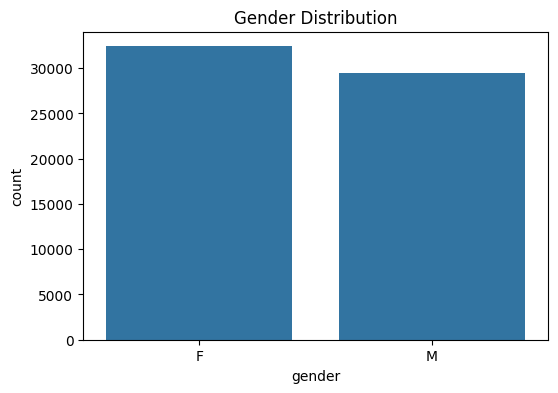

In [39]:
# gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=image_link)
plt.title('Gender Distribution')
plt.show()

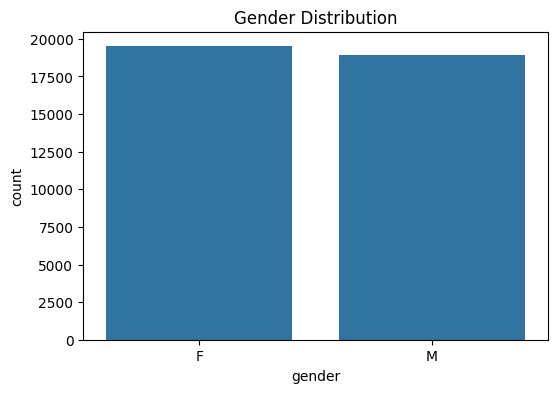

In [40]:
# gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df_merged)
plt.title('Gender Distribution')
plt.show()

# 2. Make a PCA of the embeddings
We want to see clusters of scans

In [72]:
# make a numpy array from the embedding column
emb_array = np.vstack(df_embeddings['embedding'].values)
print(emb_array.shape)
emb_array

(40544, 1376)


array([[ 0.12571079, -1.8030074 ,  1.2842511 , ..., -0.7076767 ,
         1.0859656 ,  0.02559637],
       [-0.12371061, -1.2277083 ,  0.81394076, ..., -1.669256  ,
         0.74485016, -0.6464299 ],
       [-0.45668712, -1.995114  ,  0.7816418 , ...,  0.15635946,
         1.7558306 , -0.5997554 ],
       ...,
       [-0.0462219 , -1.9575974 ,  0.65582377, ..., -1.9257301 ,
         0.9880406 , -0.42611787],
       [ 0.08438494, -1.8283029 ,  0.80794024, ..., -0.33999625,
         1.743613  , -0.5411337 ],
       [-0.03341227, -1.678429  ,  0.76011676, ..., -1.6180495 ,
         0.64806   , -1.2408257 ]], dtype=float32)

In [77]:
# run a PCA on the embeddings to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_reduced = pca.fit_transform(emb_array)

# print explained variance ratio
print(f"Explained variance ratio by 2 components: {pca.explained_variance_ratio_}")

Explained variance ratio by 2 components: [0.20919554 0.11213332]


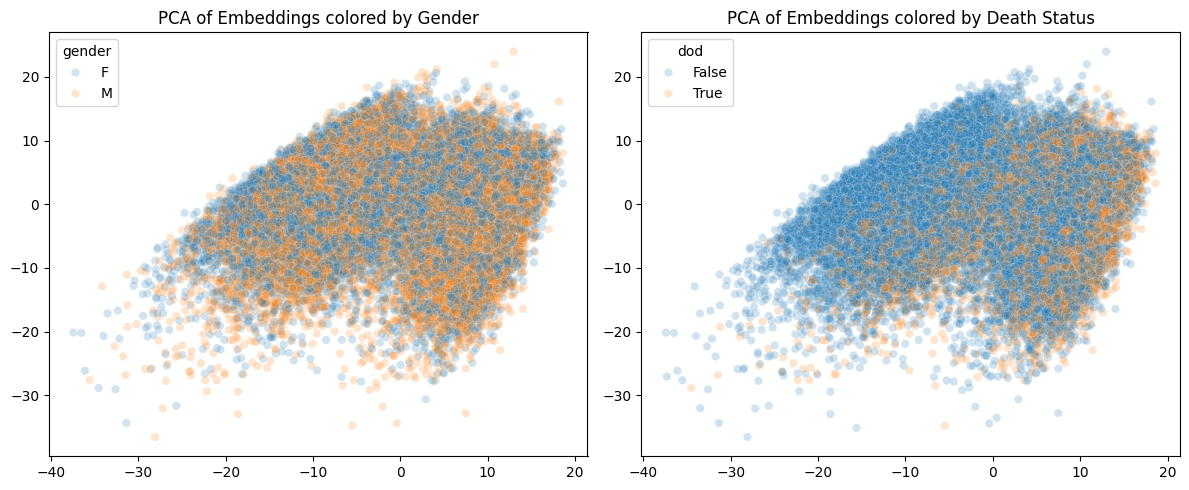

In [80]:
# make two scatter plots, where the first uses gender and the second if dod is not null
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=df_merged['gender'], alpha=0.2)
plt.title('PCA of Embeddings colored by Gender')
plt.subplot(1,2,2)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=df_merged['dod'].notnull(), alpha=0.2)
plt.title('PCA of Embeddings colored by Death Status')
plt.tight_layout()  
plt.show()

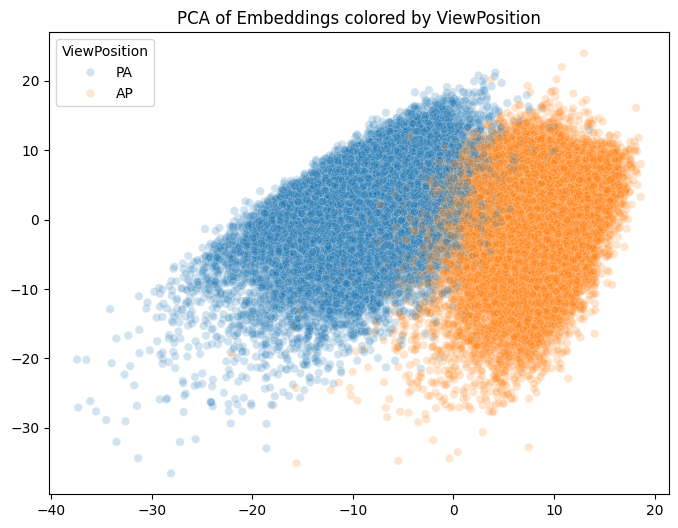

In [89]:
# scatter plot of first two PCA components colored by 'ViewPosition'
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=df_merged['ViewPosition'], alpha=0.2)
plt.title('PCA of Embeddings colored by ViewPosition')
plt.show() 

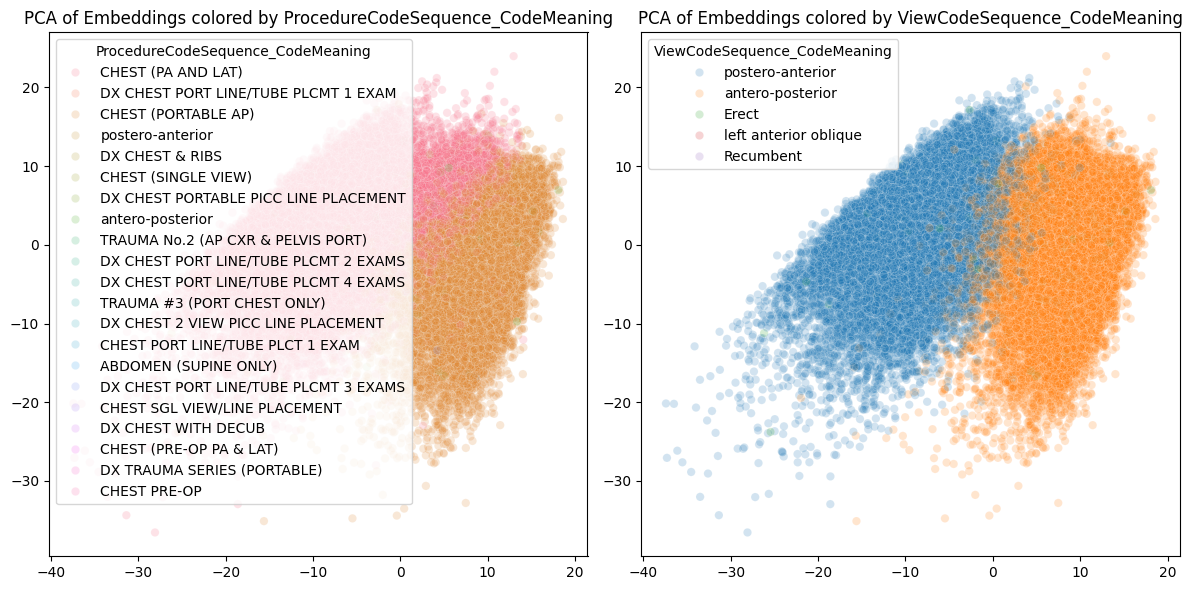

In [90]:
# scatter plot of ProcedureCodeSequence_CodeMeaning	and ViewCodeSequence_CodeMeaning
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=df_merged['ProcedureCodeSequence_CodeMeaning'], alpha=0.2)
plt.title('PCA of Embeddings colored by ProcedureCodeSequence_CodeMeaning')
plt.subplot(1,2,2)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=df_merged['ViewCodeSequence_CodeMeaning'], alpha=0.2)
plt.title('PCA of Embeddings colored by ViewCodeSequence_CodeMeaning')
plt.tight_layout()  
plt.show()